In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from PIL import Image

# ----------------------------
# Disjoint Set Union (Union-Find)
# ----------------------------
class DSU:
    def __init__(self, n):
        self.parent = np.arange(n, dtype=np.int32)
        self.size = np.ones(n, dtype=np.int32)
        # Internal difference (Int(C)): max edge weight in the component's MST so far
        self.int_diff = np.zeros(n, dtype=np.float32)

    def find(self, x):
        # Path compression
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x

    def union(self, a, b, w):
        ra, rb = self.find(a), self.find(b)
        if ra == rb:
            return ra
        # Union by size
        if self.size[ra] < self.size[rb]:
            ra, rb = rb, ra
        self.parent[rb] = ra
        self.size[ra] += self.size[rb]
        # Update internal difference for the merged component:
        # max of the two components' Int plus the weight of the connecting edge
        self.int_diff[ra] = max(self.int_diff[ra], self.int_diff[rb], w)
        return ra

# ----------------------------
# Helper functions
# ----------------------------
def to_float_image(img: np.ndarray) -> np.ndarray:
    img = img.astype(np.float32)
    if img.ndim == 2:
        img = img[..., None]  # HxW -> HxWx1
    return img

def build_edges(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Build 8-neighborhood edges for an HxWxC image.
    Returns (u, v, w): arrays of indices (flattened) and weights.
    """
    H, W, C = img.shape
    idx = np.arange(H * W, dtype=np.int32).reshape(H, W)

    # Neighbor offsets for 8-neighborhood
    neighbors = [(0,1), (1,0), (1,1), (-1,1)]  # directed set to avoid duplicates
    edges_u = []
    edges_v = []
    edges_w = []

    flat = img.reshape(-1, C)

    for dy, dx in neighbors:
        y0 = max(0, -dy)
        y1 = min(H, H - dy)
        x0 = max(0, -dx)
        x1 = min(W, W - dx)
        p = idx[y0:y1, x0:x1].ravel()
        q = idx[y0+dy:y1+dy, x0+dx:x1+dx].ravel()
        a = flat[p]
        b = flat[q]
        # Euclidean distance in feature space
        w = np.linalg.norm(a - b, axis=1)
        edges_u.append(p)
        edges_v.append(q)
        edges_w.append(w.astype(np.float32))

    u = np.concatenate(edges_u)
    v = np.concatenate(edges_v)
    w = np.concatenate(edges_w)
    return u, v, w

def felzenszwalb_segment(img: np.ndarray, k: float = 300.0, min_size: int = 20) -> np.ndarray:
    """
    Perform FH (2004) segmentation.
    Args:
        img: HxW[xC] uint8/float32 image.
        k: scale parameter controlling preference for larger components.
        min_size: post-process to remove components smaller than this by
                  merging with the most similar neighbor.
    Returns:
        labels: HxW int32 array of component labels [0..num_components-1].
    """
    img = to_float_image(img)
    H, W, C = img.shape
    N = H * W

    # Build graph
    u, v, w = build_edges(img)

    # Sort edges by weight ascending
    order = np.argsort(w)
    u, v, w = u[order], v[order], w[order]

    # Init DSU
    dsu = DSU(N)

    # Threshold function tau(C) = k / |C|
    def threshold(root):
        return k / dsu.size[root]

    # Main pass: process edges in order
    for uu, vv, ww in zip(u, v, w):
        ra = dsu.find(uu)
        rb = dsu.find(vv)
        if ra == rb:
            continue
        m_int = min(dsu.int_diff[ra] + threshold(ra),
                    dsu.int_diff[rb] + threshold(rb))
        if ww <= m_int:
            dsu.union(ra, rb, ww)

    # Post-processing: merge very small components
    for uu, vv, ww in zip(u, v, w):
        ra = dsu.find(uu)
        rb = dsu.find(vv)
        if ra != rb:
            if dsu.size[ra] < min_size:
                dsu.union(ra, rb, ww)
            elif dsu.size[rb] < min_size:
                dsu.union(rb, ra, ww)

    # Flatten labels
    roots = np.array([dsu.find(i) for i in range(N)], dtype=np.int32)
    unique_roots, labels = np.unique(roots, return_inverse=True)
    return labels.reshape(H, W).astype(np.int32)

def random_label_colors(labels: np.ndarray, seed: int = 0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    h, w = labels.shape
    k = labels.max() + 1
    palette = rng.integers(0, 255, size=(k, 3), dtype=np.uint8)
    return palette[labels]

In [ ]:
from PIL import Image
import numpy as np

def demo(image_path, k=1000, min_size=50):
  img = Image.open(image_path)
  img_array = np.array(img)

  labels = felzenszwalb_segment(img_array, k, min_size)
  seg_vis = random_label_colors(labels, seed=42)

  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  plt.imshow(img_array)
  plt.title("Input image")
  plt.axis("off")

  plt.subplot(1,2,2)
  plt.imshow(seg_vis)
  plt.title("FH (2004) segmentation")
  plt.axis("off")
  plt.show()

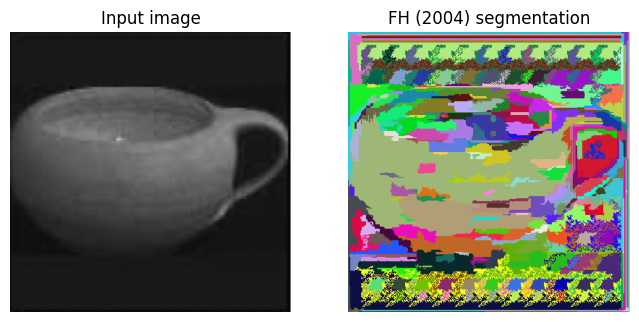

In [ ]:
demo(image_path='sample_1.png', k=100)

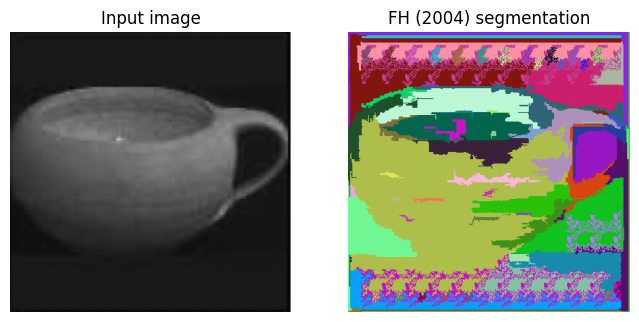

In [ ]:
demo(image_path='sample_1.png', k=1000)

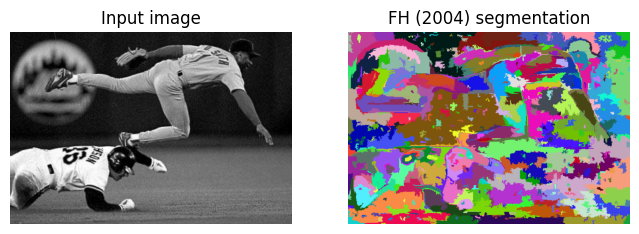

In [ ]:
demo(image_path='sample_2.png', k=1000)

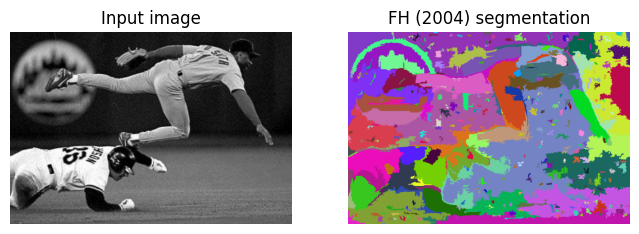

In [ ]:
demo(image_path='sample_2.png', k=3000)

# Conclusion
- Segments are niether too course not too fine.
- These segments are produced with reasoable speed.

While they don't necessarily produce the best segments, they could be a good initalizer for other computer vision operations. Eg. Object detection in R-CNNs